# Praktiskais darbs 2. Stereo attēlu dispritātes kartes un dziļuma kartes iegūšana
RTU DE0942 • Datorredze

**Mērķis:** Apgūt dziļuma informācijas ieguvi no stereo pāriem, izmantojot disparitātes aprēķinu un kameras kalibrācijas parametrus.
**Uzdevumi:**
1. Disparitātes karte bez kalibrācijas (Middlebury dati)
2. Disparitāte un dziļuma karte ar kalibrācijas datiem
3. Disparitātes un dziļuma karte ar reāliem attēliem



## prepare data

In [39]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
import reprlib

import json


In [2]:
!pip install gdown -q

In [3]:
import gdown
import os
from urllib.parse import urlparse, parse_qs

def is_folder_empty(path):
    return not any(os.scandir(path))

shared_link = 'https://drive.google.com/drive/folders/1jj8DNBjIvt7zT4ZokBSz8khXPYEU0tyI?usp=sharing'

folder_path_root = 'calibrate'
if os.path.exists(folder_path_root) is False or is_folder_empty(folder_path_root):
  print("Downloading folder...")
  # Extract the folder ID from the shared link
  parts = urlparse(shared_link)
  folder_id = parts.path.split('/')[-1]

  # Define the output directory
  output_dir = folder_path_root

  # Create the output directory if it doesn't exist
  os.makedirs(output_dir, exist_ok=True)

  # Download the folder using gdown and print output
  print("Downloading folder...")
  gdown.download_folder(id=folder_id, output=output_dir, quiet=True, use_cookies=False)
  print("Download complete.")


print(f"Folder downloaded to: {folder_path_root}")
!ls
!ls -lah $folder_path_root

Folder downloaded to: calibrate
calibrate  image_2025-10-22_220842673.png  sample_data
total 54M
drwxr-xr-x 2 root root 4.0K Oct 22 19:16 .
drwxr-xr-x 1 root root 4.0K Oct 22 19:08 ..
-rw-r--r-- 1 root root 1.7M Oct 22 19:00 IMG_20251022_214603_690.jpg
-rw-r--r-- 1 root root 1.6M Oct 22 19:00 IMG_20251022_214607_717.jpg
-rw-r--r-- 1 root root 1.7M Oct 22 19:00 IMG_20251022_214615_458.jpg
-rw-r--r-- 1 root root 1.6M Oct 22 19:01 IMG_20251022_214620_318.jpg
-rw-r--r-- 1 root root 1.9M Oct 22 19:01 IMG_20251022_214624_434.jpg
-rw-r--r-- 1 root root 2.0M Oct 22 19:01 IMG_20251022_214630_375.jpg
-rw-r--r-- 1 root root 2.1M Oct 22 19:01 IMG_20251022_214635_653.jpg
-rw-r--r-- 1 root root 2.0M Oct 22 19:01 IMG_20251022_214641_734.jpg
-rw-r--r-- 1 root root 2.0M Oct 22 19:01 IMG_20251022_214650_456.jpg
-rw-r--r-- 1 root root 2.1M Oct 22 19:01 IMG_20251022_214655_328.jpg
-rw-r--r-- 1 root root 2.1M Oct 22 19:01 IMG_20251022_214659_403.jpg
-rw-r--r-- 1 root root 2.1M Oct 22 19:01 IMG_20251022_214

In [4]:

def isGrayscale(img):
  return len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1)

def plotImage(img, title , cmap = None, colorbar_title = None):
  plt.figure(figsize=(10, 4))

  if cmap is None:
    if isGrayscale(img):
      plt.imshow(img, cmap='gray') # useful for grayscale images to avoid false coloring
    else:
      plt.imshow(img)
  else:
    plt.imshow(img, cmap=cmap)

  if colorbar_title:
    plt.colorbar(label=colorbar_title)

  plt.title(title)
  plt.axis('off')
  plt.show()

def plotImgSideBySide(img1, title1, img2, title2, subtitle=None, cmap1 = None, cmap2=None, img2_vmax=None, colorbar1_title = None, colorbar2_title = None):
  fig, axs = plt.subplots(1, 2, figsize=(16, 6))

  if cmap1 is None:
    if isGrayscale(img1):
      axs[0].imshow(img1, cmap='gray') # useful for grayscale images to avoid false coloring
    else:
      axs[0].imshow(img1)
  else:
    axs[0].imshow(img1, cmap=cmap1)

  if colorbar1_title:
    fig.colorbar(axs[0].images[0], ax=axs[0], label=colorbar1_title)
  axs[0].set_title(title1)
  axs[0].axis('off')


  if cmap2 is None:
    if isGrayscale(img2):
      axs[1].imshow(img2, cmap='gray', vmax=img2_vmax) # useful for grayscale images to avoid false coloring
    else:
      axs[1].imshow(img2, vmax=img2_vmax)
  else:
    axs[1].imshow(img2, cmap=cmap2, vmax=img2_vmax)

  if colorbar2_title:
    fig.colorbar(axs[1].images[0], ax=axs[1], label=colorbar2_title)
  axs[1].set_title(title2)
  axs[1].axis('off')

  if subtitle is not None:
    fig.suptitle(subtitle, fontsize=16)
  plt.show()

def plotImgSideBySideTriple(img1, title1, img2, title2, img3, title3):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.title(title1)
  if isGrayscale(img1):
    plt.imshow(img1, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img1)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.title(title2)
  if isGrayscale(img2):
    plt.imshow(img2, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img2)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.title(title3)
  if isGrayscale(img3):
    plt.imshow(img3, cmap='gray') # useful for grayscale images to avoid false coloring
  else:
    plt.imshow(img3)
  plt.axis('off')

  plt.show()


# Task


# Theory

* Kameras kalibrēšana ir process, kas nosaka, kā kamera pārveido 3D
pasauli 2D attēlā.
* Bez kalibrēšanas attēlā:
  - līnijas var izskatīties izliektas (optiskais kropļojums),
  - objektu izmērus un attālumus nevar precīzi noteikt,
  - stereo pāros nevar korekti aprēķināt dziļumu.
* Kalibrēšana ļauj:
  - novērst objektīva kropļojumus,
  - noteikt fokusa garumu un galveno punktu,
  - aprēķināt reālos mērogus un attālumus no attēla,
  - sagatavot kameru stereo redzei un 3D rekonstrukcijai.

Kalibrēšanas rezultāts ir divu tipu parametri:
 - Iekšējie (intrinsic), raksturo pašas
kameras optiku un sensoru.
    - fokusa garumi (pikseļos)
    - attēla centrs
    - kropļojuma koeficienti
 - Ārējie (extrinsic), raksturo kameras
pozīciju un orientāciju telpā.
    - 𝑅: rotācijas matrica
    - 𝑡: translācijas vektors

Reālām lēcām ir:
 - Radiālais kropļojums: 𝑘1 , 𝑘2 , 𝑘3
 - Tangenciālais kropļojums: 𝑝1 , 𝑝2
 - Modelis: 𝑥𝑑𝑖𝑠𝑡 = 𝑥 (1 + 𝑘1 𝑟^2 + 𝑘2 𝑟^4 + 𝑘3 𝑟^6) + 2𝑝1 𝑥𝑦
+ 𝑝2 (𝑟^2 + 2𝑥^2)
 - Kalibrācija ļauj šos koeficientus noteikt un attēlus
izlīdzināt (undistort).

Kalibrēšanas praktiskie ieguvumi
- Pareizs ģeometriskais attēls
Noņem izliektas malas, padara taisnas līnijas taisnas.
- Reālistisks dziļuma aprēķins
Disparitātes aprēķins kļūst precīzs, ja zināms fokusa garums un bāzes
attālums.
- Mērījumu uzticamība
Var noteikt attālumus, izmērus, laukumus milimetros vai metros.
- Labāka stereo rektifikācija
Attēli tiek izlīdzināti, lai atbilstības būtu vienā rindā.
- Neironu tīklu ievade
Precīzāki dati ļauj labāk mācīt modeļus (piemēram, dziļuma kartes vai 3D
segmentāciju).

Kalibrācija apraksta kameras īpašības, nevis konkrētu attālumu
- Kameras iekšējie parametri (intrinsics):
  - fokusa garums 𝑓𝑥 , 𝑓𝑦 ,
  - attēla centrs 𝑐𝑥 , 𝑐𝑦 ,
- kropļojuma koeficienti (𝑘1 , 𝑘2 , 𝑝1 , 𝑝2 ) ir nemainīgi, kamēr:
  - tu nemaini fokusa attālumu (zoom),
  - tu nepārvietojies uz citu fokusa režīmu (piem., auto → macro),
  - tu neizmaini izšķirtspēju vai sensors nav kustīgs.
- Tātad kalibrāciju vari izmantot visiem attālumiem — tā “izlabo” lēcas
un sensoru ģeometriju.

Kas jāievēro pie kalibrācijas
- Kalibrācijas dati kļūst mazāk precīzi, ja:
  - šablons tika fotografēts tikai ļoti tuvu kamerai, bet objekti pēc tam ir tālu (vai
otrādi);
  - šablons bija tikai vienā leņķī, bet lietojumā objekti ir citos skatījumos;
  - objektīvs ir ar mainīgu fokusa garumu (zoom) un tas mainās starp
uzņemšanām;
  - kamera ir mobilā ierīce ar maināmu autofokusu — fokusa garums var
mainīties automātiski.

**Ieteikumi
precīzai
kalibrēšanai**
- Fotografē šaha dēli dažādos attālumos un
leņķos, lai modelis būtu stabils.
- Ja paredzēts darbs aptuveni vienā diapazonā
(piem., 0.5–2 m), tad kalibrē arī apmēram šajā
diapazonā.
- Ja maini zoom vai fokusa režīmu – jākalibrē
no jauna.
- Ja strādā ar viedtālruņiem, centies fiksēt
fokusu (lock focus) pirms attēlu uzņemšanas.

**Tipiskās
kļūdas**
- Neprecīza kalibrācija (maz attēlu, slikts leņķu
sadalījums)
- Attēlu rotācija vai novirze starp kadriem
- Gaismas un ekspozīcijas atšķirības
- Vienmuļas virsmas bez tekstūras
- Pārāk maza bāze (mazs BBB)

Kā atrast fokusa garumu?
(Zhanga metode)
 - Fotografē zināmu šablonu (piem., šaha laukumu)
no dažādiem leņķiem.
 - Atrod stūra punktus katrā attēlā.
 -  Aprēķina projekcijas matricas un iegūst 𝐾, 𝑅, 𝑡.
 -  Optimizē, samazinot projicēšanas kļūdu 𝑒

- Katrs šaha dēļa stūra punkts ir zināms reālajā pasaulē (X, Y, 0).
- Kad mēs šos punktus redzam dažādās attēla pozīcijās, mēs iegūstam
daudzas vienādojumu sistēmas
- Ar vienu attēlu mēs nevaram unikāli noteikt visus parametrus (pārāk
maz datu). Tāpēc:
- uzņemam vairākus attēlus,
- katrs attēls dod jaunus vienādojumus,
- tiek atrisināts kopīgs optimizācijas uzdevums.

Kā tiek atrasts fokusa garums
- Zināmi pasaules punkti (šaha dēļa koordinātas)
- Zināmi to pikseļu koordinātas attēlā
- Nezināmie: 𝑓𝑥 , 𝑓𝑦 , 𝑐𝑥 , 𝑐𝑦 , 𝑘1 , 𝑘2 , . . .
- Zhang metode atrisina optimizācijas problēmu
- Tiek meklētas tādas 𝑓𝑥 , 𝑓𝑦 ,kas vislabāk atbilst visiem attēliem
vienlaikus, samazinot projicēšanas kļūdu starp reālo un aprēķināto
stūri.

###3. Disparitātes un dziļuma karte ar reāliem attēliem
* Ar savu viedtālruni uzņemt vismaz 10 foto ar šaha laukuma šablonu (no dažādiem leņķiem un attālumiem).
* Izmantot cv.findChessboardCorners() un cv.calibrateCamera() lai:
noteiktu kameras matricu 𝐾un kropļojuma koeficientus 𝑑𝑖𝑠𝑡,
saglabā rezultātu camera_calib_params.npz.
* Fotografēt divus attēlus (viena aina, bet kamera nobīdīta horizontāli par zināmu bāzi 𝐵, piemēram, 6 cm).
* Izveidot:
  * Disparitātes karti ar StereoSGBM
  * Dziļuma karti, izmantojot 𝑓no kalibrācijas un 𝐵 no mērījuma
* Vizualizēt un kvalitatīvi salīdzināt rezultātus ar Middlebury datiem.


In [5]:
"""
  Kalibrācija – cv.findChessboardCorners, cv.calibrateCamera()
  Attēlu izlīdzināšana (undistort) – cv.undistort()
  Rektifikācija – cv.stereoRectify()

  https://forum.opencv.org/t/asymmetric-circle-grid-calibration/21121/8
  https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/
"""

'\n  Kalibrācija – cv.findChessboardCorners, cv.calibrateCamera()\n  Attēlu izlīdzināšana (undistort) – cv.undistort()\n  Rektifikācija – cv.stereoRectify()\n\n  https://forum.opencv.org/t/asymmetric-circle-grid-calibration/21121/8\n  https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/\n'

In [37]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

########################################Blob Detector##############################################

# Setup SimpleBlobDetector parameters.
blobParams = cv2.SimpleBlobDetector_Params()

#blobParams.minDistBetweenBlobs = 5;

# Change thresholds
#blobParams.minThreshold = 10
#blobParams.maxThreshold = 200

#blobParams.filterByColor = True
#blobParams.blobColor = 0

# Filter by Area.
blobParams.filterByArea = True
blobParams.minArea = 20 #64     # filter out all the blobs that have less then xx pixels.
blobParams.maxArea = 35000   # 25k 7 picture

# Filter by Circularity
#blobParams.filterByCircularity = True
#blobParams.minCircularity = 0.01

# Filter by Convexity
#blobParams.filterByConvexity = True
#blobParams.minConvexity = 0.87

# Filter by Inertia
#blobParams.filterByInertia = True
#blobParams.minInertiaRatio = 0.01

# Create a detector with the parameters
blobDetector = cv2.SimpleBlobDetector_create(blobParams)

###################################################################################################

###################################################################################################

# Original blob coordinates, supposing all blobs are of z-coordinates 0
# And, the distance between every two neighbour blob circle centers is 72 centimetres
# In fact, any number can be used to replace 72.
# Namely, the real size of the circle is pointless while calculating camera calibration parameters.
objp = np.zeros((44, 3), np.float32)
objp[0]  = (0  , 0  , 0)
objp[1]  = (0  , 72 , 0)
objp[2]  = (0  , 144, 0)
objp[3]  = (0  , 216, 0)
objp[4]  = (36 , 36 , 0)
objp[5]  = (36 , 108, 0)
objp[6]  = (36 , 180, 0)
objp[7]  = (36 , 252, 0)
objp[8]  = (72 , 0  , 0)
objp[9]  = (72 , 72 , 0)
objp[10] = (72 , 144, 0)
objp[11] = (72 , 216, 0)
objp[12] = (108, 36,  0)
objp[13] = (108, 108, 0)
objp[14] = (108, 180, 0)
objp[15] = (108, 252, 0)
objp[16] = (144, 0  , 0)
objp[17] = (144, 72 , 0)
objp[18] = (144, 144, 0)
objp[19] = (144, 216, 0)
objp[20] = (180, 36 , 0)
objp[21] = (180, 108, 0)
objp[22] = (180, 180, 0)
objp[23] = (180, 252, 0)
objp[24] = (216, 0  , 0)
objp[25] = (216, 72 , 0)
objp[26] = (216, 144, 0)
objp[27] = (216, 216, 0)
objp[28] = (252, 36 , 0)
objp[29] = (252, 108, 0)
objp[30] = (252, 180, 0)
objp[31] = (252, 252, 0)
objp[32] = (288, 0  , 0)
objp[33] = (288, 72 , 0)
objp[34] = (288, 144, 0)
objp[35] = (288, 216, 0)
objp[36] = (324, 36 , 0)
objp[37] = (324, 108, 0)
objp[38] = (324, 180, 0)
objp[39] = (324, 252, 0)
objp[40] = (360, 0  , 0)
objp[41] = (360, 72 , 0)
objp[42] = (360, 144, 0)
objp[43] = (360, 216, 0)
###################################################################################################

#objp=np.array([[0,0,0],[1,0,0],[2,0,0],[3,0,0],[0.5,0.5,0],[1.5,0.5,0],[2.5,0.5,0],[3.5,0.5,0]])
#for y in range(2,11):
#        for x in range(4):
#                objp=np.append(objp,[np.array([objp[4*(y-2)+x][0],objp[4*(y-2)+x][1]+1,0])],axis=0)
circle_spacing = 1
#objp = np.zeros((6*7, 3), np.float32)
#objp[:, :2] = np.mgrid[0:6, 0:7].T.reshape(-1, 2) * circle_spacing


PATT_SIZE = (4,11)
# For circles grid → apply spacing correction
objp[:, :2] = np.zeros((PATT_SIZE[0] * PATT_SIZE[1], 2), np.float32)
for i in range(PATT_SIZE[1]):
    for j in range(PATT_SIZE[0]):
        objp[i * PATT_SIZE[0] + j, 0] = j * 1.0 + 0.5 * (i % 2)
        objp[i * PATT_SIZE[0] + j, 1] = i * (np.sqrt(3) / 2)

#Copied from: python 3.x - Camera calibration with circular pattern - Stack Overflow - <https://stackoverflow.com/questions/39272510/camera-calibration-with-circular-pattern>

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


#Copied from: Camera Calibration Using a Circle Grid | Longer Vision Technology - <https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/>

checking calibrate/IMG_20251022_214607_717.jpg... found 0
Detected 46 blobs
checking calibrate/IMG_20251022_214721_555.jpg... found 0
Detected 49 blobs
checking calibrate/IMG_20251022_214630_375.jpg... found 0
Detected 64 blobs
checking calibrate/IMG_20251022_214655_328.jpg... found 0
Detected 45 blobs
checking calibrate/IMG_20251022_214641_734.jpg... found 0
Detected 46 blobs
checking calibrate/IMG_20251022_214603_690.jpg... found 0
Detected 51 blobs
found pattern 0


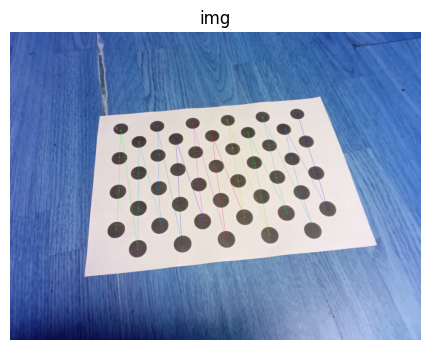

checking calibrate/IMG_20251022_214750_423.jpg... found 1
Detected 47 blobs
checking calibrate/IMG_20251022_214807_924.jpg... found 1
Detected 44 blobs
checking calibrate/IMG_20251022_214650_456.jpg... found 1
Detected 48 blobs
checking calibrate/IMG_20251022_214635_653.jpg... found 1
Detected 47 blobs
checking calibrate/IMG_20251022_214744_221.jpg... found 1
Detected 44 blobs
found pattern 1


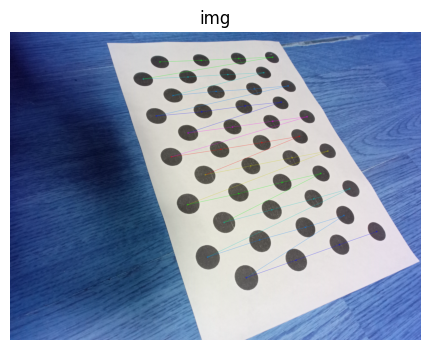

checking calibrate/IMG_20251022_214755_086.jpg... found 2
Detected 45 blobs
checking calibrate/IMG_20251022_214803_210.jpg... found 2
Detected 50 blobs
found pattern 2


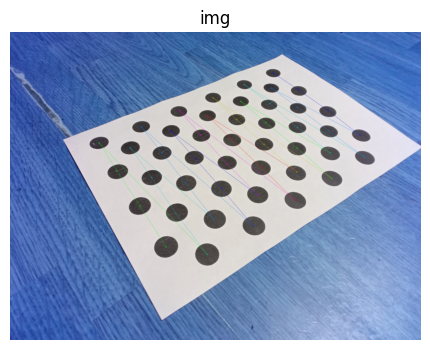

checking calibrate/IMG_20251022_214732_288.jpg... found 3
Detected 44 blobs
checking calibrate/IMG_20251022_214702_522.jpg... found 3
Detected 46 blobs
found pattern 3


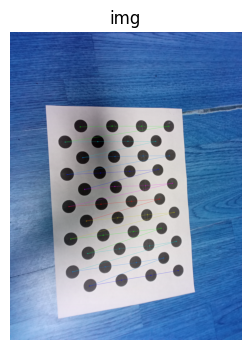

checking calibrate/IMG_20251022_214624_434.jpg... found 4
Detected 44 blobs
found pattern 4


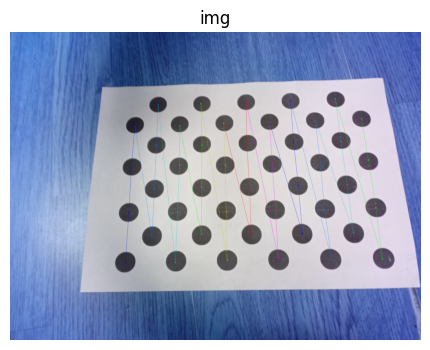

checking calibrate/IMG_20251022_214821_600.jpg... found 5
Detected 52 blobs
checking calibrate/IMG_20251022_214615_458.jpg... found 5
Detected 48 blobs
checking calibrate/IMG_20251022_214830_487.jpg... found 5
Detected 54 blobs
checking calibrate/IMG_20251022_214620_318.jpg... found 5
Detected 51 blobs
found pattern 5


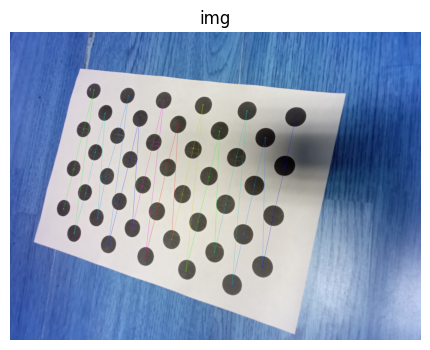

checking calibrate/IMG_20251022_214713_267.jpg... found 6
Detected 48 blobs
found pattern 6


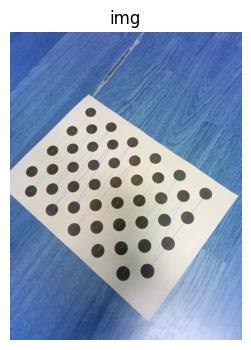

checking calibrate/IMG_20251022_214718_344.jpg... found 7
Detected 48 blobs
found pattern 7


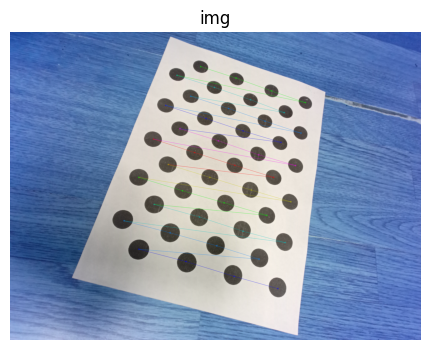

checking calibrate/IMG_20251022_214739_592.jpg... found 8
Detected 44 blobs
checking calibrate/IMG_20251022_214709_683.jpg... found 8
Detected 49 blobs
checking calibrate/IMG_20251022_214815_000.jpg... found 8
Detected 51 blobs
checking calibrate/IMG_20251022_214758_521.jpg... found 8
Detected 44 blobs
checking calibrate/IMG_20251022_214659_403.jpg... found 8
Detected 47 blobs
found pattern 8


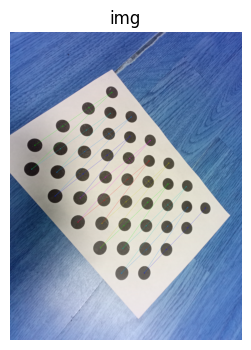

checking calibrate/IMG_20251022_214729_051.jpg... found 9
Detected 40 blobs
Found 9 images

=== Calibration Result ===
Reprojection error: 24.638590583180328

Camera matrix:
 [[2.54269488e+04 0.00000000e+00 4.98227044e+02]
 [0.00000000e+00 1.71999938e+04 9.23620490e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Camera matrix f_px:
 25426.94881270503

Distortion coefficients:
 [-1.46043831e+00 -3.46229754e+02  8.39984181e-01 -8.01453820e-02
  9.35031465e+03]



In [41]:
import time
#cap = cv2.VideoCapture(0)
found = 0


#while(found < 10):  # Here, 10 can be changed to whatever number you like to choose
for image in os.listdir(folder_path_root):
    #ret, img = cap.read() # Capture frame-by-frame
    filename = f'{folder_path_root}/{image}'

    print(f"checking {filename}... found {found}")
    img = cv2.imread(filename)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plotImage(gray, "img", cmap='gray')

    keypoints = blobDetector.detect(gray) # Detect blobs.
    #print(f"keypoints: {keypoints}")

    print(f"Detected {len(keypoints)} blobs")
    img_with_blobs = cv2.drawKeypoints(img, keypoints, None, (0, 0, 255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #plotImage(img_with_blobs, 'blobs')

    # Draw detected blobs as red circles. This helps cv2.findCirclesGrid() .
    im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #plotImage(im_with_keypoints, "im_with_keypoints")
    im_with_keypoints_gray = cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findCirclesGrid(gray, PATT_SIZE, None, flags = cv2.CALIB_CB_ASYMMETRIC_GRID+ cv2.CALIB_CB_CLUSTERING, blobDetector=blobDetector)   # Find the circle grid
    #ret, corners = cv2.findCirclesGrid(gray, PATT_SIZE, None, flags = cv2.CALIB_CB_SYMMETRIC_GRID+ cv2.CALIB_CB_CLUSTERING, blobDetector=blobDetector)   # Find the circle grid

    if ret == True:
        print(f"found pattern {found}")
        objpoints.append(objp)  # Certainly, every loop objp is the same, in 3D.

        corners2 = cv2.cornerSubPix(im_with_keypoints_gray, corners, (11,11), (-1,-1), criteria)    # Refines the corner locations.
        imgpoints.append(corners2)

        # Draw and display the corners.
        im_with_keypoints = cv2.drawChessboardCorners(img, PATT_SIZE, corners2, ret)
        found += 1

    #cv2.imshow("img", im_with_keypoints) # display
        plotImage(im_with_keypoints, "img", cmap='gray')
    #cv2.waitKey(2)


    #time.sleep(0.1)  # equivalent to waitKey(100)

print(f"Found {found} images")
# When everything done, release the capture
#cap.release()
#cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print('\n=== Calibration Result ===')
print(f'Reprojection error: {ret}')
print('\nCamera matrix:\n', mtx)
print('\nCamera matrix f_px:\n', mtx[0,0])
print('\nDistortion coefficients:\n', dist.ravel())
print('\n===========================')

yaml_data = {
    'pattern_type': 'asymmetric_circles',
    'pattern_size': PATT_SIZE,
    'reprojection_error': float(ret),
    'camera_matrix': mtx.tolist(),
    'cam0': mtx.tolist(), #K
    'baseline': 0.1, #m
    'distortion_coefficients': dist.ravel().tolist()
}

calib_file = 'calib'
with open(f'{calib_file}.json', 'w') as f_json:
    json.dump(yaml_data, f_json, indent=4)

np.savez(f'{calib_file}.npz',
         cam0=mtx,
         baseline=0.1,
         distortion_coefficients=dist,
         rvecs=rvecs,
         tvecs=tvecs)

#Copied from: Asymmetric Circle Grid Calibration - Python - OpenCV - <https://forum.opencv.org/t/asymmetric-circle-grid-calibration/21121/5>
#Copied from: Camera Calibration Using a Circle Grid | Longer Vision Technology - <https://longervision.github.io/2017/03/18/ComputerVision/OpenCV/opencv-internal-calibration-circle-grid/>

### 4. Iesniegšanas kontrolsaraksts
ORTUSā jāiesniedz:
- [ ] Programmas kods (.ipynb)
- [ ] Oriģinālie Middlebury datu kopas attēli (stereo pāris)
- [ ] Disparitātes karte (attēls) bez kalibrācijas
- [ ] Dziļuma karte ar Middlebury kalibrācijas datiem
- [ ] Savi attēli (stereo pāris) un kalibrācijas failu
- [ ] Disparitātes un dziļuma kartes no saviem attēliem
- [ ] Secinājumi (var tikt pievienoti teksta laukā, darba iesniegšanas uzdevumi, vai kā atsēvišķš pdf fails)